In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__)
    print(module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib
3.1.2
numpy
1.17.4
pandas
0.25.3
sklearn
0.22
tensorflow
2.0.0
tensorflow_core.keras
2.2.4-tf


## 1. 准备并处理数据

In [2]:
# 获取数据集
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
# 格式化展示数据
from pprint import pprint
pprint(housing.data[0:3])
pprint(housing.target[0:3])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02]])
array([4.526, 3.585, 3.521])


In [4]:
# 划分数据集
from sklearn.model_selection import train_test_split
x_train_all , x_test, y_train_all, y_test = train_test_split(housing.data, 
                                                             housing.target,
                                                             random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,
                                                      y_train_all,
                                                      random_state=2)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. 建立模型

### 2.1 【重点】建立自定义损失函数

In [6]:
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [7]:
# tf.reduce_mean()方法一览
x = tf.constant([[1., 1.], [2. ,2.]])
print(tf.reduce_mean(x, keepdims=True))
print(tf.reduce_mean(x, keepdims=False))
print(tf.reduce_mean(x, axis=1, keepdims=True))
print(tf.reduce_mean(x, axis=1, keepdims=False))

tf.Tensor([[1.5]], shape=(1, 1), dtype=float32)
tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(
[[1.]
 [2.]], shape=(2, 1), dtype=float32)
tf.Tensor([1. 2.], shape=(2,), dtype=float32)


In [8]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

model.summary()
model.compile(loss=customized_mse, 
              optimizer="sgd",
              metrics=["mean_squared_error"])
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## 3. 训练模型

In [9]:
history = model.fit(x_train_scaled, 
                    y_train,
                    epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 81us/sample - loss: 1.0241 - mean_squared_error: 1.0241 - val_loss: 0.5428 - val_mean_squared_error: 0.5428
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5702 - mean_squared_error: 0.5702 - val_loss: 0.4959 - val_mean_squared_error: 0.4959
Epoch 3/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4964 - mean_squared_error: 0.4964 - val_loss: 0.4866 - val_mean_squared_error: 0.4866
Epoch 4/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4868 - mean_squared_error: 0.4868 - val_loss: 0.4789 - val_mean_squared_error: 0.4789
Epoch 5/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4787 - mean_squared_error: 0.4787 - val_loss: 0.4745 - val_mean_squared_error: 0.4745
Epoch 6/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4818 - mean_squar

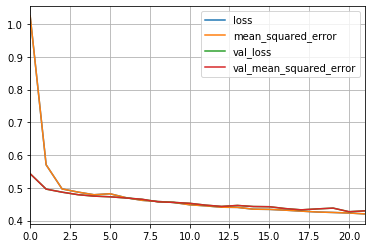

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(6, 4), grid=True)
    plt.show()
plot_learning_curves(history)

## 4. 模型预测

In [11]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.44086655747982884, 0.4408666]